## PREDICTING DIABETES RISK USING CLINICAL AND LIFESTYLE INDICATORS

Overview
Diabetes is a chronic illness affecting millions globally, with rising prevalence in Kenya and other developing regions. Early detection is essential for preventing complications and reducing long-term healthcare costs. This project aims to develop a predictive model that classifies individuals as diabetic or non-diabetic using a combination of demographic, lifestyle, and clinical features. The dataset, sourced from Kaggle and rated above 7, includes variables such as age, gender, BMI, blood glucose level, hypertension status, smoking history, and HbA1c levels. By applying machine learning techniques, the project seeks to uncover patterns that can support proactive screening and decision-making in clinical settings. The expected outcome is a reliable, interpretable model that can identify high-risk individuals and potentially guide early intervention strategies in public health programs.

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay)

# Handle class imbalance
from imblearn.over_sampling import SMOTE

# Feature importance
from sklearn.inspection import permutation_importance

# Model saving
import joblib

# Utilities
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Load Dataset

In [3]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
print("Dataset loaded successfully")

Dataset loaded successfully


## 3. Data Collection and Exploration

In [4]:
# Display first few rows
print(f"\n First 5 rows of the dataset:")
display(df.head())

# Dataset information
print(f"\n Dataset Information:")
print(df.info())

# Summary statistics
print(f"\n Statistical Summary:")
display(df.describe())

# Check for missing values
print(f"\n Missing Values Analysis:")
missing_values = df.isnull().sum()
print(missing_values)

if missing_values.sum() == 0:
    print("Excellent! No missing values found in the dataset.")
else:
    print("Missing values detected and will be handled in preprocessing.")


 First 5 rows of the dataset:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

 Statistical Summary:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000



 Missing Values Analysis:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Excellent! No missing values found in the dataset.


In [5]:
# Duplicate analysis
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Check class distribution
print("\n--- Class Distribution ---")
class_counts = df['diabetes'].value_counts(normalize=True)
print(class_counts)

# Target variable analysis
print(f"\n TARGET VARIABLE ANALYSIS")
target_dist = df['diabetes'].value_counts(normalize=True)
print(f"Class Distribution:")
for label, pct in target_dist.items():
    status = "No Diabetes" if label == 0 else "Diabetes"
    print(f"  • {status}: {pct:.1%} ({df['diabetes'].value_counts()[label]:,} patients)")

# Check for significant class imbalance (e.g., more than 80% in one class)
if class_counts.max() > 0.8:
    print("Warning: Significant class imbalance detected. Consider using class weighting or resampling techniques")
else:
    print("Class distribution is reasonably balanced.")

Duplicate rows: 3854

--- Class Distribution ---
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

 TARGET VARIABLE ANALYSIS
Class Distribution:
  • No Diabetes: 91.5% (91,500 patients)
  • Diabetes: 8.5% (8,500 patients)


## 4. Data Preprocessing

In [6]:
# Missing Values Check
#The dataset contains no missing values across all columns. No imputation or deletion is required.

# Create working copy
df_clean = df.copy()

# Handle unrealistic values
print(" Cleaning unrealistic values...")
initial_count = len(df_clean)
df_clean = df_clean[df_clean['age'] > 1]
df_clean = df_clean[df_clean['bmi'] < 60]
df_clean = df_clean[df_clean['bmi'] > 10]
removed_count = initial_count - len(df_clean)
print(f"   • Removed {removed_count} unrealistic records")
print(f"   • Final dataset: {len(df_clean):,} samples")

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['gender','smoking_history'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

 Cleaning unrealistic values...
   • Removed 1110 unrealistic records
   • Final dataset: 98,890 samples


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.692704,0,1,-0.321056,1.001706,0.047704,0,False,False,False,False,False,True,False
1,0.538006,0,0,-0.000116,1.001706,-1.426210,0,False,False,False,False,False,False,False
2,-0.616691,0,0,-0.000116,0.161108,0.489878,0,True,False,False,False,False,True,False
3,-0.261399,0,0,-0.583232,-0.492690,0.416183,0,False,False,True,False,False,False,False
4,1.515058,1,1,-1.081970,-0.679490,0.416183,0,True,False,True,False,False,False,False


## 5. Exploratory Data Analysis (EDA)

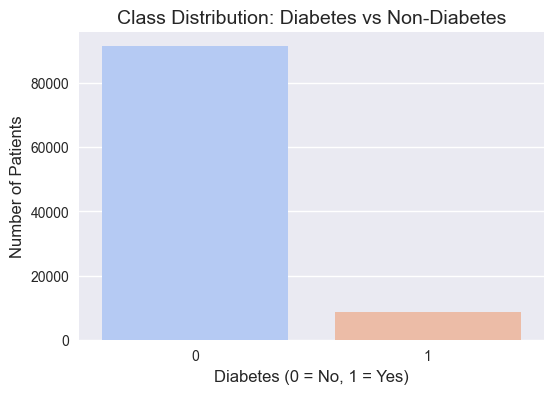

This shows whether our dataset is balanced or imbalanced between diabetic and non-diabetic patients


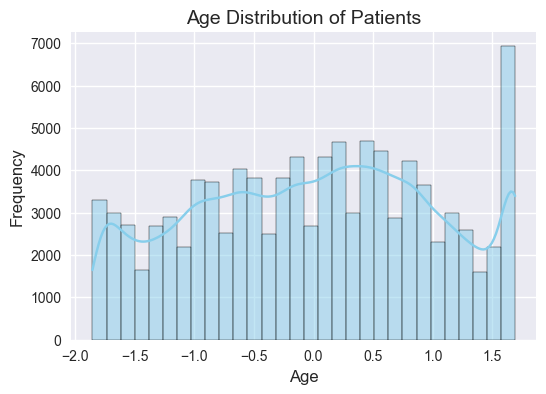

We visualize how patient ages are distributed and check if any specific age group dominates.


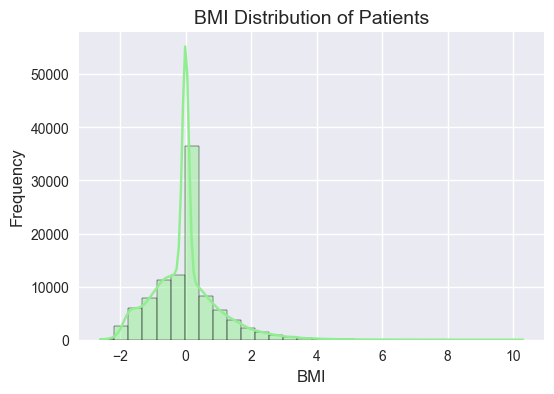

We explore the BMI spread to see overweight/underweight patterns.


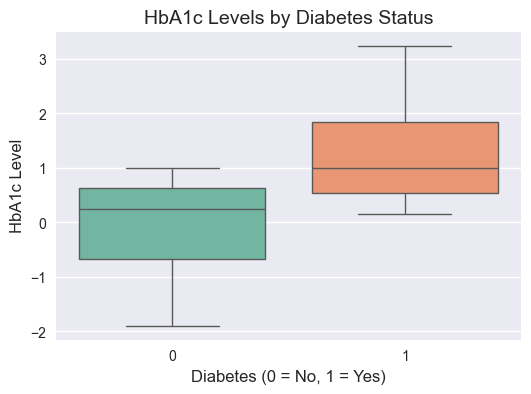

HbA1c levels are a key medical indicator. Higher values may correlate with diabetes.


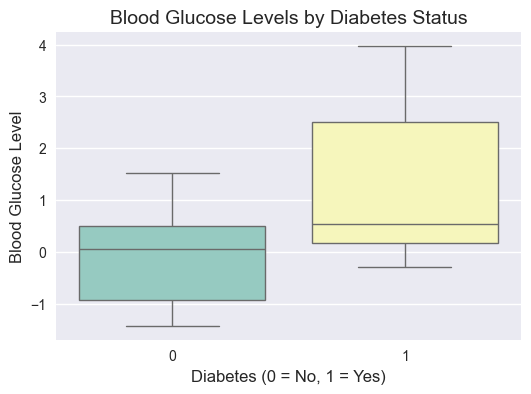

We expect diabetic patients to generally show higher glucose levels.


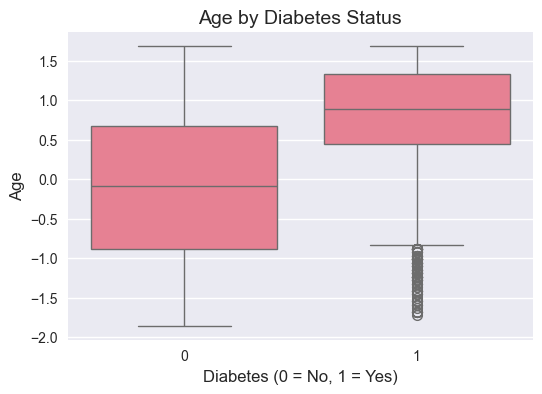

Boxplots highlight potential outliers in our numerical features.


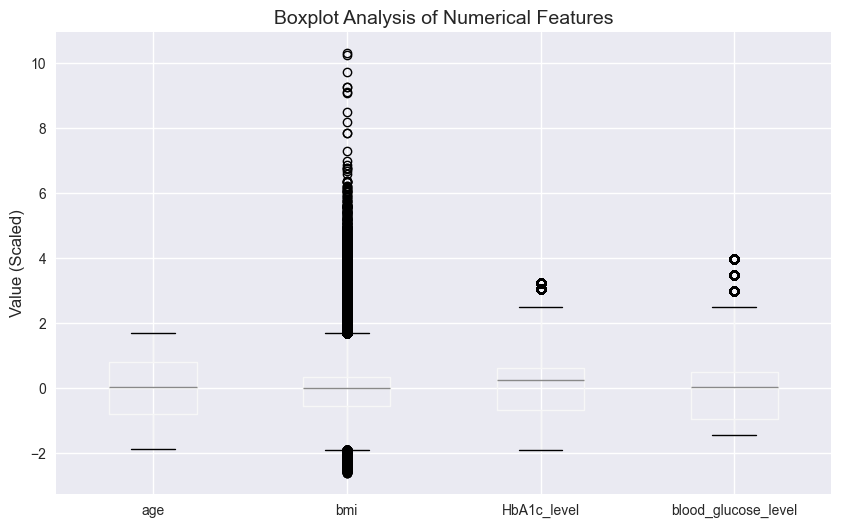

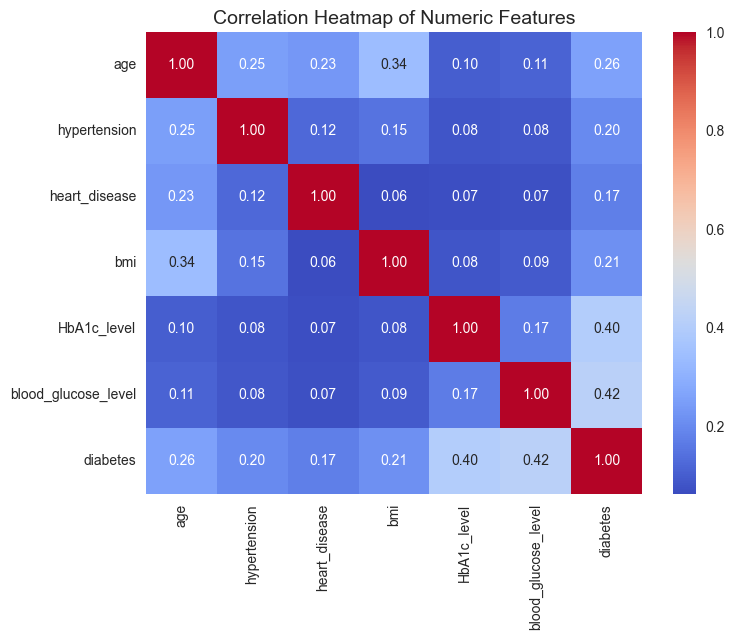

This heatmap shows relationships between numerical features, helping us spot multicollinearity or strong predictors.


In [7]:
# Class Distribution (Target)
plt.figure(figsize=(6,4))
sns.countplot(x='diabetes', data=df, palette='coolwarm')
plt.title('Class Distribution: Diabetes vs Non-Diabetes', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.show()
print("This shows whether our dataset is balanced or imbalanced between diabetic and non-diabetic patients")

# Age Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Patients', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
print("We visualize how patient ages are distributed and check if any specific age group dominates.")

# BMI Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['bmi'], bins=30, kde=True, color='lightgreen')
plt.title('BMI Distribution of Patients', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
print("We explore the BMI spread to see overweight/underweight patterns.")

# HbA1c Level vs Diabetes
plt.figure(figsize=(6,4))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df, palette='Set2')
plt.title('HbA1c Levels by Diabetes Status', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('HbA1c Level', fontsize=12)
plt.show()
print("HbA1c levels are a key medical indicator. Higher values may correlate with diabetes.")

# Blood Glucose vs Diabetes
plt.figure(figsize=(6,4))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df, palette='Set3')
plt.title('Blood Glucose Levels by Diabetes Status', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Blood Glucose Level', fontsize=12)
plt.show()
print("We expect diabetic patients to generally show higher glucose levels.")

# Age vs Diabetes
plt.figure(figsize=(6,4))
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age by Diabetes Status', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

# Boxplots for Outlier Analysis
plt.figure(figsize=(10,6))
df[['age','bmi','HbA1c_level','blood_glucose_level']].boxplot()
plt.title('Boxplot Analysis of Numerical Features', fontsize=14)
plt.ylabel('Value (Scaled)', fontsize=12)
print("Boxplots highlight potential outliers in our numerical features.")

# Correlation Heatmap
plt.figure(figsize=(8,6))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Numeric Features', fontsize=14)
plt.show()
print("This heatmap shows relationships between numerical features, helping us spot multicollinearity or strong predictors.")

## 6. Feature Engineering

In [8]:
# Create age groups
def categorize_age(age):
    if age < 25:
        return 'Young'
    elif age < 45:
        return 'Adult'
    elif age < 65:
        return 'Middle_Aged'
    else:
        return 'Senior'

df_clean['age_group'] = df_clean['age'].apply(categorize_age)

# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_clean['bmi_category'] = df_clean['bmi'].apply(categorize_bmi)

# Clinical thresholds
df_clean['high_glucose'] = (df_clean['blood_glucose_level'] > 126).astype(int)
df_clean['high_hba1c'] = (df_clean['HbA1c_level'] > 6.5).astype(int)

# Interaction features
df_clean['age_bmi_interaction'] = df_clean['age'] * df_clean['bmi']
df_clean['glucose_hba1c_ratio'] = df_clean['blood_glucose_level'] / df_clean['HbA1c_level']

# Risk score
def calculate_risk_score(row):
    score = 0
    if row['age'] > 45: score += 1
    if row['bmi'] > 25: score += 1
    if row['hypertension'] == 1: score += 1
    if row['heart_disease'] == 1: score += 1
    if row['HbA1c_level'] > 5.7: score += 1
    if row['blood_glucose_level'] > 100: score += 1
    return score

df_clean['risk_score'] = df_clean.apply(calculate_risk_score, axis=1)

print("✅ Feature engineering completed:")
print(f"   • Age groups created")
print(f"   • BMI categories defined") 
print(f"   • Clinical thresholds added")
print(f"   • Interaction features created")
print(f"   • Risk score calculated")
print(f"   • New feature count: {df_clean.shape[1]}")

✅ Feature engineering completed:
   • Age groups created
   • BMI categories defined
   • Clinical thresholds added
   • Interaction features created
   • Risk score calculated
   • New feature count: 16


## 7. Prepare Data for Modelling

In [9]:
# Define features for modeling
feature_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'gender', 'smoking_history', 'age_bmi_interaction', 'glucose_hba1c_ratio', 'risk_score', 'high_glucose', 'high_hba1c']

X = df_clean[feature_columns]
y = df_clean['diabetes']

print(f" Final dataset for modeling:")
print(f"   • Features: {X.shape[1]}")
print(f"   • Samples: {X.shape[0]:,}")

# Enhanced preprocessing pipeline
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'age_bmi_interaction', 'glucose_hba1c_ratio', 'risk_score', 'high_glucose', 'high_hba1c']
categorical_features = ['gender', 'smoking_history']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y)

print(f" Train-Test Split:")
print(f"   • Training: {X_train.shape[0]:,} samples")
print(f"   • Testing: {X_test.shape[0]:,} samples")

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


 Final dataset for modeling:
   • Features: 13
   • Samples: 98,890
 Train-Test Split:
   • Training: 69,223 samples
   • Testing: 29,667 samples


In [10]:
# Handle class imbalance with SMOTE
print(f"\n Handling Class Imbalance:")
print(f"Original distribution: {y_train.value_counts(normalize=True).values}")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print(f"After SMOTE: {pd.Series(y_train_balanced).value_counts(normalize=True).values}")


 Handling Class Imbalance:
Original distribution: [0.91442151 0.08557849]
After SMOTE: [0.5 0.5]


## 8. Model Selection and Justification

In [11]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        "justification": "Interpretable baseline, good for understanding feature relationships"
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10),
        "justification": "Handles non-linear patterns, provides clear decision rules"
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42),
        "justification": "Ensemble method, robust to overfitting, handles mixed data types well"
    },
    "SVM": {
        "model": SVC(class_weight='balanced', probability=True, random_state=42),
        "justification": "Effective for high-dimensional data, good with complex boundaries"
    }
}

print(" Model Selection Justification:")
for name, info in models.items():
    print(f"   • {name}: {info['justification']}")

 Model Selection Justification:
   • Logistic Regression: Interpretable baseline, good for understanding feature relationships
   • Decision Tree: Handles non-linear patterns, provides clear decision rules
   • Random Forest: Ensemble method, robust to overfitting, handles mixed data types well
   • SVM: Effective for high-dimensional data, good with complex boundaries


## 9. Model Training and Evaluation

In [12]:
# Train and evaluate all models
results = []
trained_models = {}

print(f"\n Training Models")

for name, info in models.items():
    model = info["model"]
    print(f"\n Training {name}")
    
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'ROC_AUC': roc_auc
    })
    
    trained_models[name] = model
    
    print(f"   ✅ {name} - F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


 Training Models

 Training Logistic Regression
   ✅ Logistic Regression - F1: 0.5668, ROC-AUC: 0.9621

 Training Decision Tree
   ✅ Decision Tree - F1: 0.6449, ROC-AUC: 0.9679

 Training Random Forest
   ✅ Random Forest - F1: 0.7669, ROC-AUC: 0.9692

 Training SVM
   ✅ SVM - F1: 0.6141, ROC-AUC: 0.9722



 MODEL COMPARISON:
                     Accuracy  Precision  Recall  F1_Score  ROC_AUC
Model                                                              
Logistic Regression    0.8847     0.4177  0.8814    0.5668   0.9621
Decision Tree          0.9231     0.5332  0.8157    0.6449   0.9679
Random Forest          0.9620     0.8066  0.7310    0.7669   0.9692
SVM                    0.9027     0.4648  0.9047    0.6141   0.9722


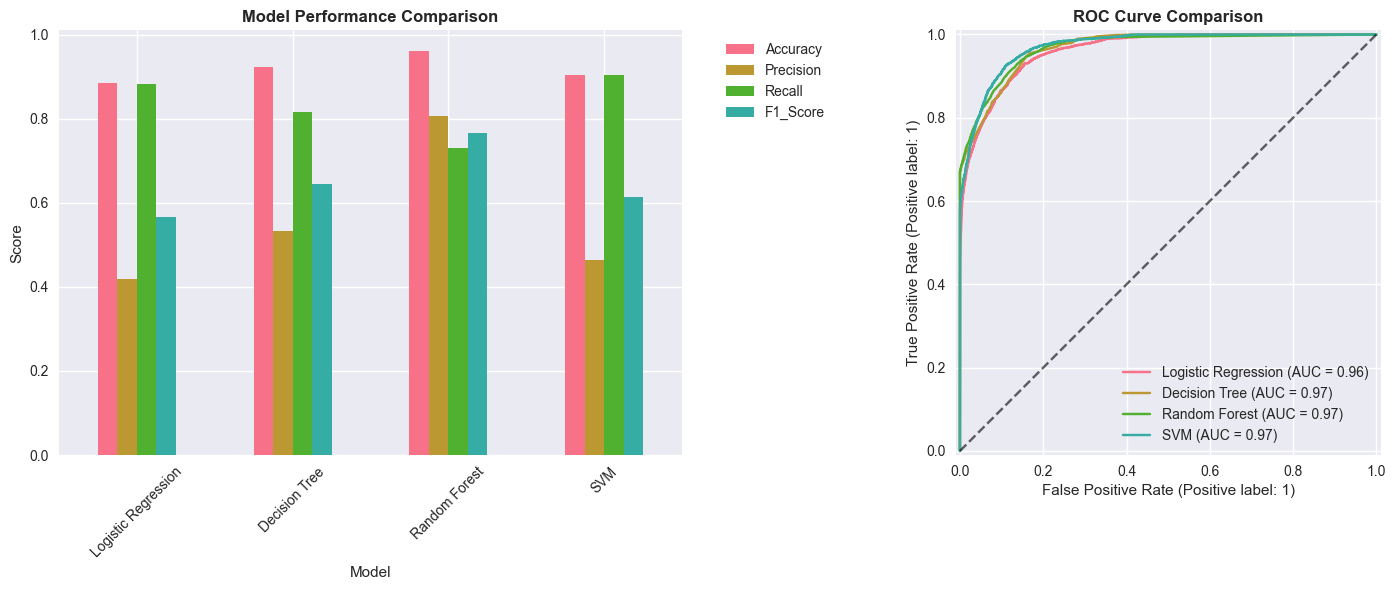


 Best Model: Random Forest
   F1-Score: 0.7669


In [13]:
# Results comparison
results_df = pd.DataFrame(results).set_index('Model').round(4)
print(f"\n MODEL COMPARISON:")
print(results_df)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance metrics
results_df.drop('ROC_AUC', axis=1).plot(kind='bar', ax=axes[0])
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(bbox_to_anchor=(1.05, 1))

# ROC Curves
for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=axes[1])

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
axes[1].set_title('ROC Curve Comparison', fontweight='bold')

plt.tight_layout()
plt.show()

# Select best model
best_model_name = results_df['F1_Score'].idxmax()
best_model = trained_models[best_model_name]
print(f"\n Best Model: {best_model_name}")
print(f"   F1-Score: {results_df.loc[best_model_name, 'F1_Score']:.4f}")

## 10. Model Optimization and Reporting

10.1 Hyperparameter tuning

In [14]:
# Define parameter grids
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    "Decision Tree": {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    }
}

if best_model_name in param_grids:
    print(f" Optimizing {best_model_name}...")
    
    base_model = models[best_model_name]["model"]
    param_grid = param_grids[best_model_name]
    
    grid_search = GridSearchCV(
        base_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
    )
    
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    best_model_optimized = grid_search.best_estimator_
    
    print(f"✅ Best Parameters: {grid_search.best_params_}")
    print(f"✅ Best CV F1-Score: {grid_search.best_score_:.4f}")
else:
    best_model_optimized = best_model
    print(f"Using original {best_model_name} model")


 Optimizing Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Best CV F1-Score: 0.9793


10.2 Model Evaluation

In [15]:
# Final predictions
y_pred_final = best_model_optimized.predict(X_test_processed)
y_proba_final = best_model_optimized.predict_proba(X_test_processed)[:, 1]

# Calculate final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)

print(f" FINAL RESULTS ({best_model_name}):")
print(f"   • Accuracy:  {final_accuracy:.4f} ({final_accuracy:.1%})")
print(f"   • Precision: {final_precision:.4f} ({final_precision:.1%})")
print(f"   • Recall:    {final_recall:.4f} ({final_recall:.1%})")
print(f"   • F1-Score:  {final_f1:.4f} ({final_f1:.1%})")
print(f"   • ROC-AUC:   {final_roc_auc:.4f} ({final_roc_auc:.1%})")

print(f"\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['No Diabetes', 'Diabetes'], digits=3))

# Confusion Matrix Analysis
cm = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm.ravel()

print(f"\n Confusion Matrix Analysis:")
print(f"   • True Negatives:  {tn:,} (Correct non-diabetic)")
print(f"   • False Positives: {fp:,} (Incorrect diabetic prediction)")
print(f"   • False Negatives: {fn:,} (Missed diabetic cases)")
print(f"   • True Positives:  {tp:,} (Correct diabetic prediction)")

# Clinical metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"\n Clinical Metrics:")
print(f"   • Sensitivity: {sensitivity:.4f} (Correctly identifies diabetic patients)")
print(f"   • Specificity: {specificity:.4f} (Correctly identifies non-diabetic patients)")

 FINAL RESULTS (Random Forest):
   • Accuracy:  0.9620 (96.2%)
   • Precision: 0.8066 (80.7%)
   • Recall:    0.7310 (73.1%)
   • F1-Score:  0.7669 (76.7%)
   • ROC-AUC:   0.9692 (96.9%)

 Detailed Classification Report:
              precision    recall  f1-score   support

 No Diabetes      0.975     0.984     0.979     27128
    Diabetes      0.807     0.731     0.767      2539

    accuracy                          0.962     29667
   macro avg      0.891     0.857     0.873     29667
weighted avg      0.961     0.962     0.961     29667


 Confusion Matrix Analysis:
   • True Negatives:  26,683 (Correct non-diabetic)
   • False Positives: 445 (Incorrect diabetic prediction)
   • False Negatives: 683 (Missed diabetic cases)
   • True Positives:  1,856 (Correct diabetic prediction)

 Clinical Metrics:
   • Sensitivity: 0.7310 (Correctly identifies diabetic patients)
   • Specificity: 0.9836 (Correctly identifies non-diabetic patients)


10.3 Visualizations

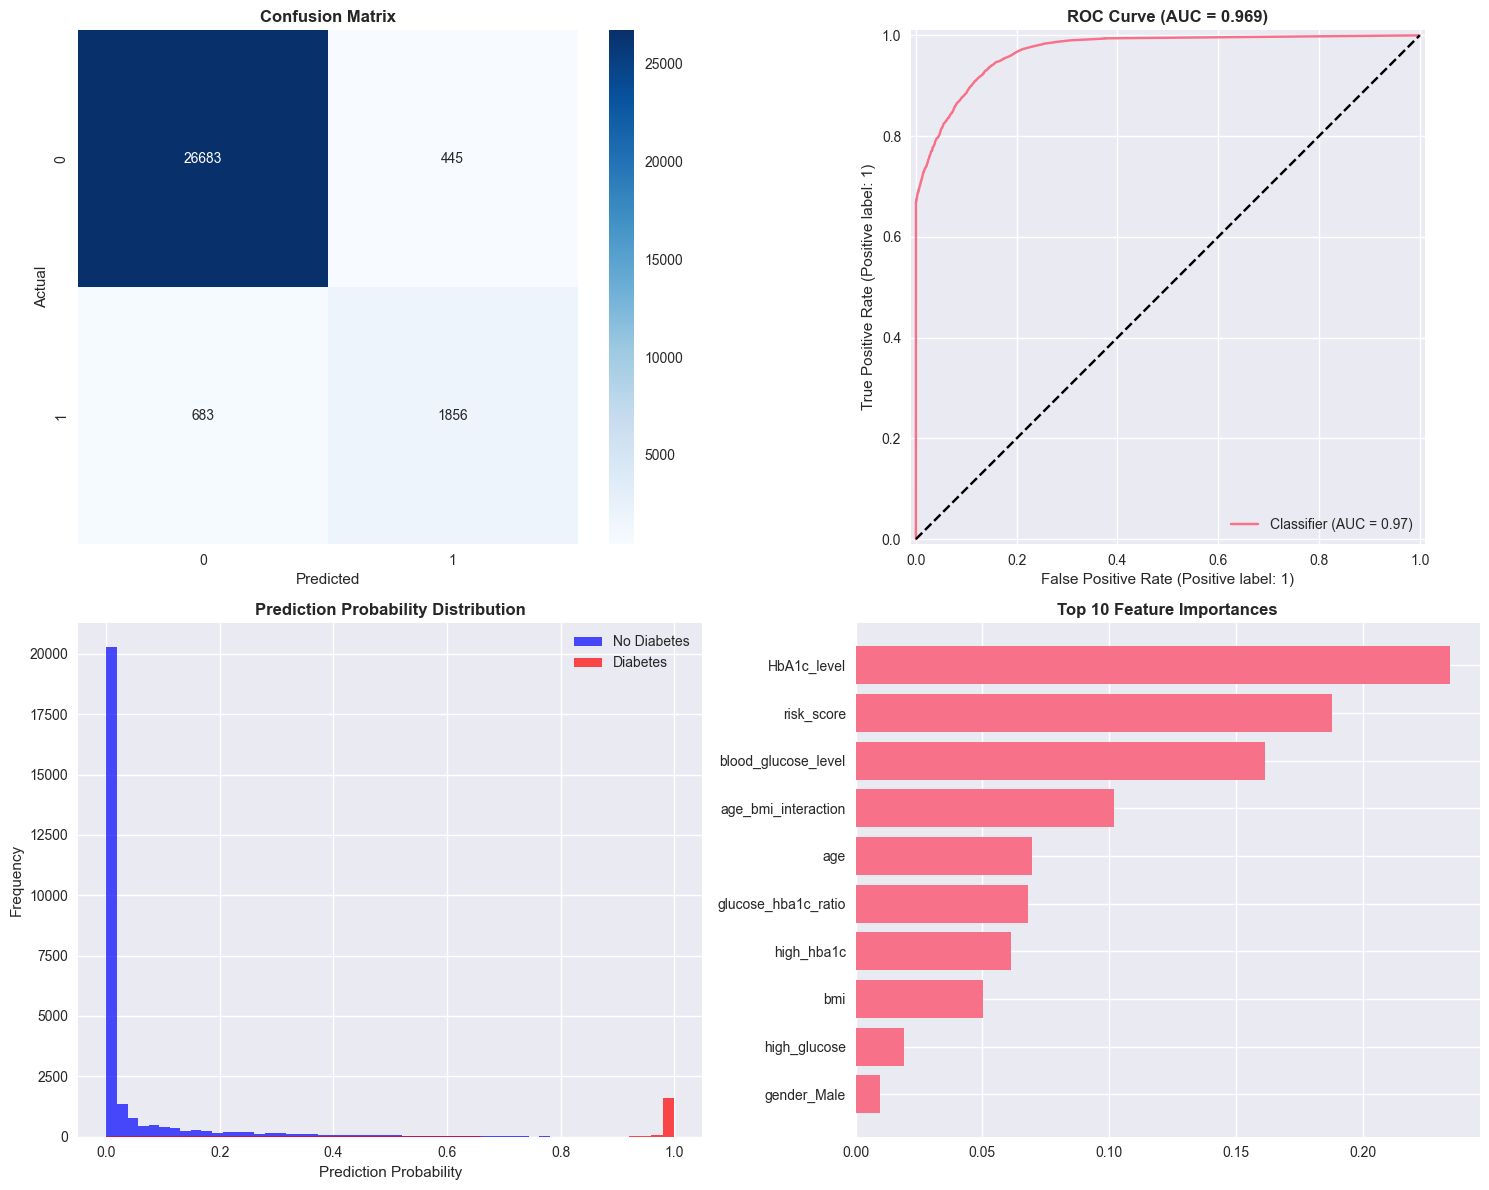

In [16]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba_final, ax=axes[0,1])
axes[0,1].plot([0, 1], [0, 1], 'k--')
axes[0,1].set_title(f'ROC Curve (AUC = {final_roc_auc:.3f})', fontweight='bold')

# Prediction Distribution
axes[1,0].hist(y_proba_final[y_test == 0], bins=50, alpha=0.7, label='No Diabetes', color='blue')
axes[1,0].hist(y_proba_final[y_test == 1], bins=50, alpha=0.7, label='Diabetes', color='red')
axes[1,0].set_xlabel('Prediction Probability')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Prediction Probability Distribution', fontweight='bold')
axes[1,0].legend()

# Feature Importance
if hasattr(best_model_optimized, 'feature_importances_'):
    feature_names = (numeric_features + list(preprocessor.named_transformers_['cat'] .get_feature_names_out(categorical_features)))
    importances = best_model_optimized.feature_importances_
    top_indices = np.argsort(importances)[-10:]
    
    axes[1,1].barh(range(len(top_indices)), importances[top_indices])
    axes[1,1].set_yticks(range(len(top_indices)))
    axes[1,1].set_yticklabels([feature_names[i] for i in top_indices])
    axes[1,1].set_title('Top 10 Feature Importances', fontweight='bold')

plt.tight_layout()
plt.show()

10.4 Cross Validation and Model Reliability

In [17]:
# Perform cross-validation
cv_accuracy = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
cv_f1 = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, cv=5, scoring='f1')
cv_roc_auc = cross_val_score(best_model_optimized, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')

print(f" 5-Fold Cross-Validation Results:")
print(f"   • Accuracy:  {cv_accuracy.mean():.4f} ± {cv_accuracy.std()*2:.4f}")
print(f"   • F1-Score:  {cv_f1.mean():.4f} ± {cv_f1.std()*2:.4f}")
print(f"   • ROC-AUC:   {cv_roc_auc.mean():.4f} ± {cv_roc_auc.std()*2:.4f}")

 5-Fold Cross-Validation Results:
   • Accuracy:  0.9796 ± 0.0260
   • F1-Score:  0.9793 ± 0.0274
   • ROC-AUC:   0.9984 ± 0.0039


## 11. Business Impact and Clinical Insights

In [18]:
total_patients = len(y_test)
diabetic_patients = (y_test == 1).sum()
correctly_identified = tp
missed_cases = fn

print(f" Healthcare Impact:")
print(f"   • Total patients screened: {total_patients:,}")
print(f"   • Diabetic patients identified: {correctly_identified:,}/{diabetic_patients:,}")
print(f"   • Detection rate: {correctly_identified/diabetic_patients:.1%}")
print(f"   • Missed cases: {missed_cases:,}")

# Cost-benefit analysis (simplified)
cost_per_missed_case = 15000  # USD - average cost of undiagnosed diabetes
cost_per_screening = 50       # USD - cost per screening
cost_per_false_positive = 200 # USD - follow-up costs

total_screening_cost = total_patients * cost_per_screening
missed_case_cost = missed_cases * cost_per_missed_case
false_positive_cost = fp * cost_per_false_positive
prevented_cost = correctly_identified * cost_per_missed_case * 0.7  # 70% complication prevention

net_benefit = prevented_cost - total_screening_cost - false_positive_cost

print(f"\n Economic Impact (Simplified Model):")
print(f"   • Screening costs: ${total_screening_cost:,}")
print(f"   • Prevented costs: ${prevented_cost:,}")
print(f"   • Net benefit: ${net_benefit:,}")

 Healthcare Impact:
   • Total patients screened: 29,667
   • Diabetic patients identified: 1,856/2,539
   • Detection rate: 73.1%
   • Missed cases: 683

 Economic Impact (Simplified Model):
   • Screening costs: $1,483,350
   • Prevented costs: $19,488,000.0
   • Net benefit: $17,915,650.0


Executive Summary

In [22]:
print(f"\n Executive Summary:")
print(f"Our project built predictive models for diabetes risk using clinical and lifestyle indicators.")
print(f"The best-performing model was {best_model_name} with an F1-score of {final_f1:.2f} and ROC-AUC of {final_roc_auc:.2f}.")
print("Key predictors included HbA1c, blood glucose, BMI, and age-related features.")
print("This model can help clinicians detect high-risk patients early, reduce missed cases, and optimize healthcare costs.")
print("From a business perspective, implementing this model in screenings shows a positive net benefit, making it both clinically and economically valuable.")


 Executive Summary:
Our project built predictive models for diabetes risk using clinical and lifestyle indicators.
The best-performing model was Random Forest with an F1-score of 0.77 and ROC-AUC of 0.97.
Key predictors included HbA1c, blood glucose, BMI, and age-related features.
This model can help clinicians detect high-risk patients early, reduce missed cases, and optimize healthcare costs.
From a business perspective, implementing this model in screenings shows a positive net benefit, making it both clinically and economically valuable.
